In [2]:
import numpy as np
import pandas as pd
import copy as cp
import pandas as pd
import matplotlib.pyplot as plt
from SlidingWindows import *
from Network import *

In [3]:
data = pd.read_csv('../data/sales_train_evaluation.csv')
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [4]:
def events_in_range(data, r):
    x = []; y = []
    for i in range(0,1941,r):
        if (i + r <= 1941):
            x.append(i // r + 1)
            y.append((r - data[i:i+r].count(None)))
    return x, y

In [5]:
N = 1941


## train X and Y have to be declared here

item_id = 'HOBBIES_1_001'
store_id = 'CA_1'
example = data[(data['item_id'] == item_id) & (data['store_id'] == 'CA_1')].to_numpy()[0][6:]
example.size

previous_days = 4
start = 1000

t = np.arange(1000, N, 1).reshape(-1,1)
x1 = np.array([example[i-1] if i - 1 >= 0 else 0 for i in range(1000,N)]).reshape(-1,1)
x2 = np.array([example[i-2] if i - 2 >= 0 else 0 for i in range(1000,N)]).reshape(-1,1)
x3 = np.array([example[i-3] if i - 3 >= 0 else 0 for i in range(1000,N)]).reshape(-1,1)
# np.insert(x1, 1, 4120, axis=0)


y = np.array(example[start:]).reshape(-1,1)
y.size

941

In [6]:
calender = pd.read_csv('../data/calendar.csv')
event_calender = calender[['event_name_1', 'event_type_1', 'd']].dropna()

mx = 1941
events = [None] * mx
for index, row  in event_calender.iterrows():
    if int(row['d'][2:]) - 1 <= mx:
        events[int(row['d'][2:]) - 1] = row['event_name_1']
    # print(row['d'])

events_x, events_y = events_in_range(events, 1)
x4 = np.array(events_y[start:]).reshape(-1,1)
x4.shape

(941, 1)

In [7]:
dataset = pd.DataFrame(np.concatenate((t, x1, x2, x3, y), axis=1), 
                       columns=['t', 'x1', 'x2', 'x3', 'y'])

deltaT = np.array([(dataset.t[i + 1] - dataset.t[i]) for i in range(len(dataset)-1)])
deltaT = np.concatenate((np.array([0]), deltaT))

dataset.insert(1, '∆t', deltaT)
dataset.head(3)

,t,∆t,x1,x2,x3,y
0,1000,0,0,0,0,2
1,1001,1,2,0,0,2
2,1002,1,2,2,0,0


In [8]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(dataset, test_size = 0.2, shuffle = False)

In [9]:
w = 5
train_constructor = WindowSlider()
train_windows = train_constructor.collect_windows(trainset.iloc[:,1:], previous_y=False)

test_constructor = WindowSlider()
test_windows = test_constructor.collect_windows(testset.iloc[:,1:], previous_y=False)

train_constructor_y_inc = WindowSlider()
train_windows_y_inc = train_constructor_y_inc.collect_windows(trainset.iloc[:,1:], previous_y=True)

test_constructor_y_inc = WindowSlider()
test_windows_y_inc = test_constructor_y_inc.collect_windows(testset.iloc[:,1:], previous_y=True)

train_windows.head(3)

,∆t(1),∆t(2),∆t(3),∆t(4),∆t(5),x1(1),x1(2),x1(3),x1(4),x1(5),...,x2(3),x2(4),x2(5),x3(1),x3(2),x3(3),x3(4),x3(5),∆t(6),Y
0,0.0,1.0,2.0,3.0,4.0,0.0,2.0,2.0,0.0,1.0,...,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,5.0,0.0
1,0.0,1.0,2.0,3.0,4.0,2.0,2.0,0.0,1.0,1.0,...,2.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,5.0,0.0
2,0.0,1.0,2.0,3.0,4.0,2.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,5.0,0.0


In [10]:
##############################################################
# TRAIN THE NETWORK AND PREDICT - Without previous values of y
##############################################################
import time

in_dim = train_windows.shape[1] - 1
NN = Network(input_dim=in_dim, hidden_dim=20, output_dim=1)
t0 = time.time()
eml_residuals = NN.train(x = train_windows.iloc[:,:-1], 
                     y = train_windows.iloc[:,-1].values.reshape(-1,1))
tF = time.time()

fit = NN.predict(train_windows.iloc[:,:-1])
predictions = NN.predict(test_windows.iloc[:,:-1])

eml_fit = cp.deepcopy(fit)
eml_pred = cp.deepcopy(predictions)

eml_residuals = eml_pred - testset.iloc[w:, -1].values.reshape(-1,1)
eml_rmse = np.sqrt(np.sum(np.power(eml_residuals,2)) / len(eml_residuals))
print('RMSE = %.2f' % eml_rmse)
print('Time to train %.2f' % (tF - t0))

SVD computed.. calculating Pseudoinverse..
W2 values updated..
RMSE = 1.22
Time to train 0.01


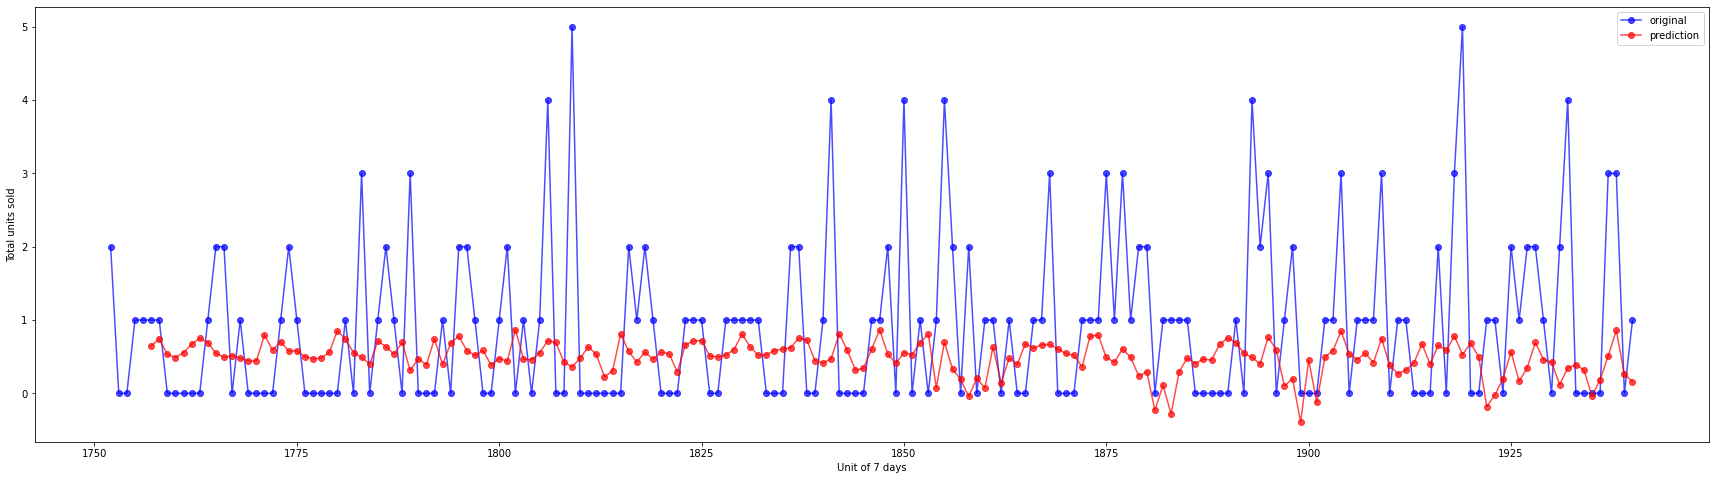

In [14]:
plt.figure(figsize=(30,8))

# lr_y_pred_train = lr_model.predict(trainset.iloc[:,:-1])

plt.plot(testset['t'], testset['y'], alpha=0.7, marker='o', c='b', label="original")
plt.plot(testset['t'][5:], predictions, alpha=0.7, marker='o', c='r', label="prediction")

plt.legend() 
plt.xlabel(f'Unit of 1 days')
plt.ylabel('Total units sold')
# plt.title(f'Graph showing sales of {item_id} for every {r} days')
plt.show()

In [16]:
###########################################################
# TRAIN THE NETWORK AND PREDICT - With previous values of y
###########################################################

in_dim = train_windows_y_inc.shape[1] - 1
NN = Network(input_dim=in_dim, hidden_dim=20, output_dim=1)
t0 = time.time()
eml_residuals = NN.train(x = train_windows_y_inc.iloc[:,:-1], 
                     y = train_windows_y_inc.iloc[:,-1].values.reshape(-1,1))
tF = time.time()

eml_fit_inc = NN.predict(train_windows_y_inc.iloc[:,:-1])
eml_pred_inc = NN.predict(test_windows_y_inc.iloc[:,:-1])

eml_residuals_inc = eml_pred_inc - testset.iloc[w:, -1].values.reshape(-1,1)
eml_rmse_inc = np.sqrt(np.sum(np.power(eml_residuals_inc,2)) / len(eml_residuals_inc))
print('RMSE = %.2f' % eml_rmse_inc)
print('Time to train %.2f' % (tF - t0))

SVD computed.. calculating Pseudoinverse..
W2 values updated..
RMSE = 1.21
Time to train 1.42


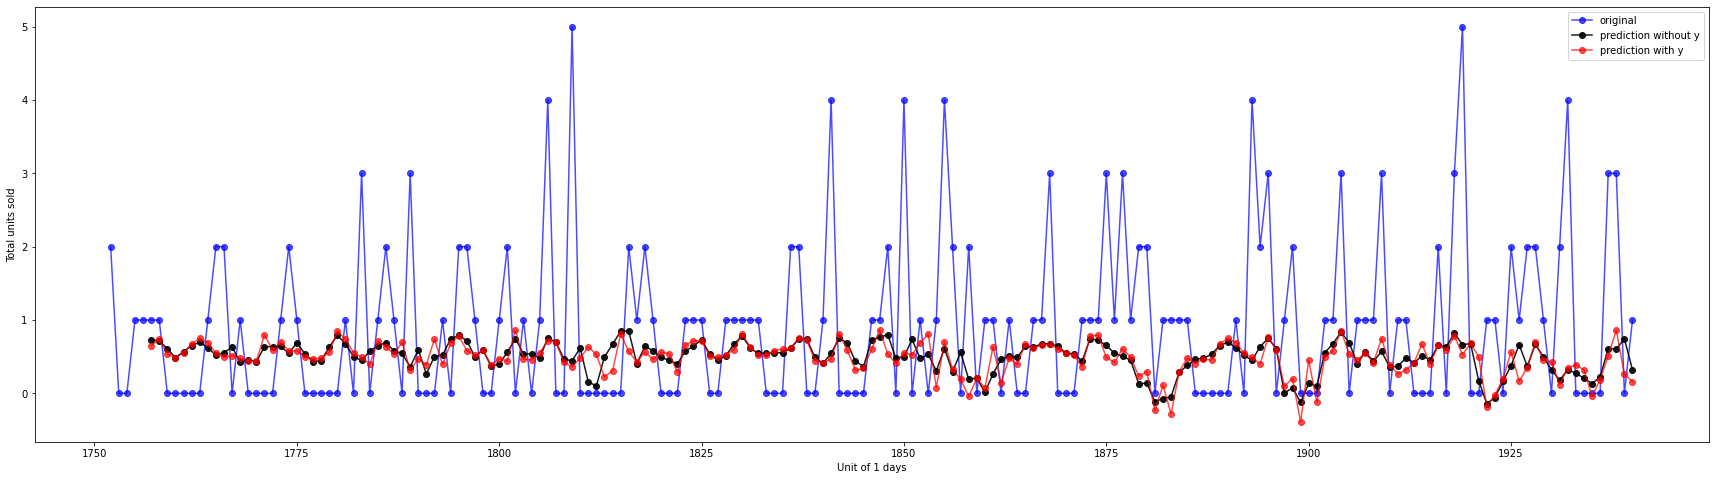

In [20]:
plt.figure(figsize=(30,8))

# lr_y_pred_train = lr_model.predict(trainset.iloc[:,:-1])

plt.plot(testset['t'], testset['y'], alpha=0.7, marker='o', c='b', label="original")
plt.plot(testset['t'][5:], eml_pred_inc, alpha=0.9, marker='o', c='black', label="prediction without y")
plt.plot(testset['t'][5:], predictions, alpha=0.7, marker='o', c='r', label="prediction with y")

plt.legend() 
plt.xlabel(f'Unit of 1 days')
plt.ylabel('Total units sold')
# plt.title(f'Graph showing sales of {item_id} for every {r} days')
plt.show()